# Introduction to Retrieval-Augmented Generation (RAG) Workflows

In this notebook, we will explore common workflows for Retrieval-Augmented Generation (RAG). RAG is a powerful technique that combines the strengths of information retrieval and natural language generation to produce more accurate and contextually relevant responses when compared to classic LLM generation. This approach is particularly useful in scenarios where the model needs to generate responses based on a large corpus of documents or knowledge base.

## Objectives
- Understand the basic concepts of Retrieval-Augmented Generation.
- Learn how to set up a retrieval system to fetch relevant documents.
- Integrate the retrieval system with a generation model to produce augmented responses.
- Explore different use cases and applications of RAG.

## Prerequisites
- Very basic understanding of natural language processing (NLP) and machine learning.
- Familiarity with Python programming.

## Notebook Overview
1. **Data Preparation**: Load and preprocess the corpus of documents.
2. **Data Transformation**: Explore tokenization and vector embeddings.
3. **Simple Retrieval System Setup**: Implement a simple vector-based retrieval system to fetch relevant documents based on a query.
4. **Generative Model Integration**: Combine the simple retrieval system with a generation model to produce responses.
5. **Advanced Retrieval System Setup**: Implement a more advanced retrieval system, using HNSW and BM25.
6. **Evaluation**: Assess the performance of the RAG system using appropriate metrics.

Let's get started by setting up our environment and loading the necessary libraries.

In [8]:
%pip install requests
%pip install tqdm
%pip install hnswlib
%pip install rank_bm25
%pip install gensim
%pip install datasets
%pip install llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu125/

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu125/
Note: you may need to restart the kernel to use updated packages.


## Data Preparation

In this section, we will prepare some simple example data, and also load the corpus of documents that will be used for retrieval.

### Step 1: Prepare Simple Sentence Data

In [9]:
# Sample text corpus: list of sentences
sentences = [
    "The cat sat on the mat, enjoying the warm sun.",
    "The dog sat on the log, watching the world go by.",
    "Cats and dogs are both popular pets, each with unique characteristics.",
    "I love my pets because they provide companionship and joy.",
    "Pets bring joy to our lives and teach us responsibility.",
    "Training pets can be a rewarding experience for both the owner and the animal.",
    "Cats are often independent, while dogs typically seek companionship.",
    "Many families consider pets as part of their family unit.",
    "Adopting a pet can change your life and bring immense happiness.",
    "Understanding pet behavior is key to building a strong bond with them.",
]



### Step 2: Load Dataset

We will use the `datasets` library to load a sample dataset. For this example, we will use the "Ankush-Chandler/cricket-wiki" dataset, which contains wikipedia articles related to the sport of Cricket.


In [10]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Ankush-Chander/cricket-wiki")


With the data prepared, we are now ready to experiment with tokenization and embedding generation!

## Data Transformation

### Word2Vec Tokenization and Embedding Generation using Gensim

In this section, we use the Gensim library to train a Word2Vec model on a sample corpus of sentences. The steps involved are:

1. **Tokenization**: Each sentence in the corpus is converted to lowercase and split into individual words.
2. **Training the Word2Vec Model**: The tokenized sentences are used to train a Word2Vec model. The model parameters include:
   - `vector_size`: The dimensionality of the word vectors.
   - `window`: The maximum distance between the current and predicted word within a sentence.
   - `min_count`: Ignores all words with a total frequency lower than this.
   - `sg`: Training algorithm, 0 for CBOW (Continuous Bag of Words) and 1 for Skip-gram.
3. **Retrieving Embeddings**: After training, we can retrieve the vector embeddings for specific words using the trained model.

This process transforms the textual data into numerical vectors that can be used for various downstream tasks such as similarity calculations and clustering.

In [11]:
from gensim.models import Word2Vec

# Tokenization
tokenized_sentences = [sentence.lower().split() for sentence in sentences]

# Training the Word2Vec model
model = Word2Vec(
    sentences=tokenized_sentences, vector_size=5, window=5, min_count=1, sg=0
)


# Getting token embeddings
def get_embedding(word):
    try:
        return model.wv[word]
    except KeyError:
        print(f"{word} not in vocabulary")
        return None


# Example of retrieving embeddings for specific words
words_to_embed = ["cat", "dog", "pets", "love"]

for word in words_to_embed:
    embedding = get_embedding(word)
    if embedding is not None:
        print(f"Embedding for '{word}': {embedding}")

Embedding for 'cat': [ 0.00195631  0.06170145 -0.1361549  -0.02765821  0.153407  ]
Embedding for 'dog': [-0.13408305 -0.14154093 -0.0498537   0.10293507 -0.07326301]
Embedding for 'pets': [ 0.14758061 -0.03021737 -0.09021993  0.13067764 -0.09709436]
Embedding for 'love': [-0.00807143 -0.16731687 -0.11181911  0.14187092  0.06698985]


### TODO: Byte Pair Encoding (BPE) Example with GPT-2 Tokenization Scheme


### TODO: BERT Embedding Finetuning

### Nomic Model for Embedding Generation

In this section, we use the Nomic model to generate embeddings for our simple sentence data. The Nomic model is designed to produce high-quality vector representations of text, which we will be using to perform similarity search. 

In [12]:
import requests
from tqdm import tqdm

# Define the Ollama API endpoint and your model
EMBEDDING_API_URL = "http://localhost:11434/api/embeddings"
EMBEDDING_MODEL_NAME = "nomic-embed-text"


def generate_embedding(prompt):
    payload = {
        "model": EMBEDDING_MODEL_NAME,
        "prompt": prompt,
    }

    response = requests.post(EMBEDDING_API_URL, json=payload)

    if response.status_code == 200:
        return response.json().get("embedding", "")
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None


nomic_embeddings = []
for sentence in tqdm(sentences):
    sentence_embedding = generate_embedding(sentence)
    nomic_embeddings.append(sentence_embedding)

100%|██████████| 10/10 [00:01<00:00,  9.03it/s]


With our sentence embeddings now generated, we are ready to start retrieving!

## Simple Retrieval System Setup

In this section, we will implement a simple retrieval system to fetch relevant documents based on a query. The retrieval system will use cosine similarity to measure the similarity between the query and the documents.



### Cosine Similarity 

This function will compute the cosine similarity between two vectors. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. In our context, it will allow us to determine how similar the embeddings of two sentences are. This operation is O(N), where N is the embedding dimension of the vectors.


In [13]:
import numpy as np


def cosine_similarity(vec_a, vec_b):
    # Compute the dot product
    dot_product = np.dot(vec_a, vec_b)

    # Compute the magnitudes (norms) of the vectors
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)

    # Calculate cosine similarity
    if norm_a == 0 or norm_b == 0:
        return 0.0  # Handle division by zero if any vector is zero
    return dot_product / (norm_a * norm_b)


### Simple Vector Search:
This function will iterate over the items in `nomic_embeddings` and return the most similar item to the query based on cosine similarity. This operation is of course O(S*N), where S is the number of sentences and N is the embedding dimension.


In [14]:
def vector_db_search(query_embedding):
    # Initialize variables to track the most similar text and its score
    most_similar_text = ""
    most_similar_score = -1

    # Loop through the list of sentence embeddings to find the most similar one
    for index, sentence_embedding in enumerate(nomic_embeddings):
        # Compute cosine similarity between the question embedding and the current sentence embedding
        computed_cosine_similarity = cosine_similarity(
            query_embedding, sentence_embedding
        )

        # Check if the computed similarity is higher than the previous best score
        if computed_cosine_similarity > most_similar_score:
            most_similar_score = computed_cosine_similarity
            most_similar_text = sentences[index]  # Update the most similar text

    return (most_similar_text, most_similar_score)

Now that we have a very simple vector database, let's start RAG'ing!

## Generative Model Integration

In this section, we will integrate the retrieval system with a generative model to produce augmented responses. The goal is to combine the strengths of information retrieval and natural language generation to generate more accurate and contextually relevant responses. The steps involved are:

1. **Query Embedding Generation**: Generate an embedding for the user's query using the Nomic model.
2. **Retrieve Relevant Document**: Use the simple vector search function to find the most similar document to the query from the vector database.
3. **Prepare Prompt for Generative Model**: Create a prompt that includes the user's query and the retrieved document to provide context for the generative model.
4. **Generate Response**: Use the generative model to produce a response based on the prepared prompt.

This process ensures that the generative model has access to relevant information from the document corpus, leading to more informed and accurate responses.

In [15]:
import requests

# Define the Ollama API endpoint and your model
MODEL_API_URL = "http://localhost:11434/api/chat"
MODEL_NAME = "llama3.1:8b"


def generate_text(prompt):
    payload = {
        "model": MODEL_NAME,
        "messages": [{"role": "user", "content": prompt}],
        "max_completion_tokens": 256,  # Adjust max tokens for desired length
        "temperature": 0.7,  # Adjust temperature for randomness
        "seed": 12,
        "stream": False,
    }

    response = requests.post(MODEL_API_URL, json=payload)

    if response.status_code == 200:
        return response.json().get("message").get("content")
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [24]:
# User's question
our_question = "Where did the cat sit?"


def simple_rag_process(question):
    # Generate an embedding for the user's question
    the_embedding_of_our_question = generate_embedding(question)

    # Query the vector DB
    most_similar_text, score = vector_db_search(the_embedding_of_our_question)

    # Print the user's question and the most similar sentence in a formatted way
    print(
        f"Our query: '{question}'\n"
        f"Most similar sentence in our vector DB: '{most_similar_text}'\n"
        f"Cosine Similarity Score: {score:.4f}\n"
    )

    # Prepare the prompt for the RAG model using the most similar text
    rag_prompt_template = f"""
    You are an assistant for question answering tasks. Use the information between the <context> </context> blocks to help answer the question. If you don't know, say 'I dunno'.

    Here is the user's question: {question}

    <context> {most_similar_text} </context>
    """

    # Print the prompt for RAG generation
    print("### RAG GENERATION ###")
    print(generate_text(rag_prompt_template))

    # Print the result of regular text generation based on the original question
    print("\n### REGULAR GENERATION ###")
    print(generate_text(question))


simple_rag_process(our_question)

Our query: 'Where did the cat sit?'
Most similar sentence in our vector DB: 'The cat sat on the mat, enjoying the warm sun.'
Cosine Similarity Score: 0.7404

### RAG GENERATION ###
The cat sat on the mat.

### REGULAR GENERATION ###
The question doesn't provide enough context or information about where the cat sat. Could you provide more details or clarify what you're asking? I'd be happy to try and help!


### But wait! There is a big issue here:

In [25]:
# User's question
our_question = "Now that I know that the cat sat on the mat. Where did the dog sit?"

simple_rag_process(our_question)

Our query: 'Now that I know that the cat sat on the mat. Where did the dog sit?'
Most similar sentence in our vector DB: 'The cat sat on the mat, enjoying the warm sun.'
Cosine Similarity Score: 0.7350

### RAG GENERATION ###
I dunno. There is no information about a dog or where it might have sat.

### REGULAR GENERATION ###
I think there might be some confusion here. The original statement was "the cat sat on the mat", but it didn't mention anything about a dog sitting anywhere. We can start fresh and create a new scenario if you'd like, or I can simply say that we don't have any information about where the dog sat! Would you like to explore further?


To fix this, we can do a few different things. The first could be to return more results from the vector DB. This might allow us to retrieve the correct sentence, but will require us to pollute the model context window with potentially irrelevant information.

Let's try Rewrite, Retrieve, Read

### Rewrite Retrieve Read

In this section, we will implement the Rewrite Retrieve Read (RRR) process, which can be a key component of the Retrieval-Augmented Generation (RAG) workflow. The RRR process involves three main steps:

1. **Rewrite**: Refine the user's query to make it more specific and clear. This helps in retrieving more relevant documents.
2. **Retrieve**: Use the refined query to search the vector database and retrieve the most relevant document.
3. **Read**: Generate a response based on the retrieved document and the original query.

This process ensures that the generative model has access to the most relevant information, leading to more accurate and contextually appropriate responses.

In [28]:
# Original query
original_query = "Now that I know that the cat sat on the mat. Where did the dog sit?"
print("Our original prompt: " + original_query + "\n")
# Step 1: Rewrite the query
refined_prompt = generate_text(
    "Rewrite the following question to make it more specific (if necessary) and remove any part of it that isn't related to the question it asks: <QUESTION>"
    + original_query
    + "</QUESTION> --- Only return the rewritten query"
)

print("Our modified prompt: " + refined_prompt + "\n")

simple_rag_process(refined_prompt)

Our original prompt: Where did the dog sit?

Our modified prompt: What location did the dog sit in?

Our query: 'What location did the dog sit in?'
Most similar sentence in our vector DB: 'The dog sat on the log, watching the world go by.'
Cosine Similarity Score: 0.7273

### RAG GENERATION ###
The dog sat on a log.

### REGULAR GENERATION ###
I don't think we've discussed a specific location related to a dog sitting. This conversation just started, and I'm happy to help if you'd like to ask a question or provide more context!


By using an LLM to summarize our user's question, we managed to get much better results. This type of RAG operation can be structured as a multi-agent system. We can designate our summarization as a "Rewrite" agent and our generation as an "Expert" agent. The "Rewrite" agent refines the user's query to make it more specific and clear, ensuring that the retrieval process fetches the most relevant documents. The "Expert" agent then uses these documents to generate accurate and contextually appropriate responses. This multi-agent approach enhances the overall performance and reliability of the RAG system, making it more effective in handling complex queries.

Now that we have nice example of RAG on simple sentences, let's extend it to more complex documents, like the cricket dataset we introduced earlier. The cricket dataset is much larger, so we'll need to scale up our least efficient component, the vector DB, so that it keeps up with the demands of our dataset.

Let's get into a more **Advanced Retrieval System**!

## Advanced Retrieval System Setup

In this section, we will implement a more advanced retrieval system to enhance the accuracy and efficiency of document retrieval. We will explore two advanced techniques: Hierarchical Navigable Small World (HNSW) graphs and BM25.

1. **HNSW (Hierarchical Navigable Small World) Graphs**: HNSW is a highly efficient algorithm for approximate nearest neighbor search. It constructs a graph where nodes represent data points, and edges represent proximity based on a distance metric. This allows for fast and accurate retrieval of the most similar documents.

2. **BM25 (Best Matching 25)**: BM25 is a ranking function used by search engines to estimate the relevance of documents to a given query. It is based on the probabilistic information retrieval model and considers factors such as term frequency, document length, and inverse document frequency.


In [19]:
# Generate embeddings for the cricket dataset
sampled_dataset = dataset["train"].shuffle(seed=42).select(range(100))
cricket_embeddings = []
for example in tqdm(sampled_dataset):
    cricket_embedding = generate_embedding(example["text"])
    cricket_embeddings.append(cricket_embedding)

100%|██████████| 100/100 [00:09<00:00, 10.24it/s]



### HNSW Graphs

We will use the `hnswlib` library to implement HNSW for our retrieval system. The steps involved are:

1. **Index Construction**: Build an HNSW index using the document embeddings.
2. **Querying**: Use the HNSW index to find the nearest neighbors of the query embedding.


In [20]:
import hnswlib
import numpy as np

# Initialize the HNSW index
dim = 768  # Dimension of the embeddings
num_elements = len(cricket_embeddings)
hnsw_index = hnswlib.Index(space="cosine", dim=dim)

# Initialize the index
hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=16)

# Add items to the index
hnsw_index.add_items(cricket_embeddings)


def hnsw_search(query_embedding, hnsw_index, k=1):
    labels, distances = hnsw_index.knn_query(query_embedding, k=k)
    return labels[0], distances[0]


query_embedding = generate_embedding("Tell me about the history of cricket.")
labels, distances = hnsw_search(query_embedding, hnsw_index)
print(sampled_dataset)
most_similar_text = sampled_dataset[int(labels[0])]["text"]
print(most_similar_text)

Dataset({
    features: ['id', 'revid', 'url', 'title', 'text'],
    num_rows: 100
})
School Field Ground is a sports ground owned by Cranbrook School located in the town of Cranbrook, Kent. It is known by the school as Big Side Playing Field. The field, which is in size, is used by the school for cricket, rugby union and hockey.
Cricket history.
The ground has been used as a cricket field since at least the mid 19th century, at which point it was in private hands. Kent County Cricket Club played two first-class cricket matches on a ground specifically prepared on the site, one in 1850 and the other in 1851, both against England XIs. Kent also played two first-class matches at nearby Swifts Park in 1862–63.
The ground has been used by the school since the 1940s, including for matches against teams such as MCC. Both a South African Universities team and a South Africa Schools XI played on the ground in 1967 whilst apartheid was in operation. In July 1968 Free Foresters played a United S


### BM25

We will use the `rank_bm25` library to implement BM25 for our retrieval system. The steps involved are:

1. **Index Construction**: Build a BM25 index using the tokenized documents.
2. **Querying**: Use the BM25 index to rank documents based on their relevance to the query.


In [21]:
from rank_bm25 import BM25Okapi

# Tokenize the documents
tokenized_corpus = [doc["text"].split(" ") for doc in sampled_dataset]

# Initialize the BM25 index
bm25 = BM25Okapi(tokenized_corpus)


def bm25_search(query, bm25, k=1):
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    top_n = np.argsort(doc_scores)[::-1][:k]
    return top_n, doc_scores[top_n]


query = "19:30 IST"
top_n, scores = bm25_search(query, bm25)
most_similar_text = sampled_dataset[int(top_n[0])]["text"]
print(most_similar_text)

The opening ceremony of the fifth season of Indian Premier League (IPL) took place on the evening of 3 April 2012 in the YMCA College of Physical Education, Chennai. The ceremony was designed by Wizcraft Entertainment, and began at 19:30 IST, lasting almost two and half hours. The tickets for the ceremony were priced at and were available online at the official website of the IPL from 16 March 2012. Similar to the previous versions, the captains of the nine participating teams took the "MCC Spirit of Cricket" pledge. Various Bollywood actors, dancers, and musicians performed in the ceremony.
Background.
The event was planned to be held at M. A. Chidambaram Stadium, but was shifted to the YMCA College of Physical Education ground. The capacity of the YMCA college was lesser than that of the M. A. Chidambaram Stadium, and this caused disappointment. Tamil Nadu Cricket Association said that the decision was made because the opening match was to be played at the M. A. Chidambaram Stadium, 

Now let's create a more advanced RAG process:

In [22]:
# User's question
our_question = (
    "When was the opening ceremony of the fifth season of the Indian Premier League?"
)


def rag_process(question):
    # Generate an embedding for the user's question
    the_embedding_of_our_question = generate_embedding(question)

    # Query the vector DB
    labels, distances = hnsw_search(the_embedding_of_our_question, hnsw_index, k=1)
    hnsw_context = sampled_dataset[int(labels[0])]["text"]

    # Query the BM25 Index
    top_n, scores = bm25_search(query, bm25, k=1)
    bm25_context = sampled_dataset[int(top_n[0])]["text"]

    # Print the user's question and the most similar sentence in a formatted way
    print(
        f"Our query: '{question}'\n"
        f"Most similar paragraph in our vector DB: \n '{sampled_dataset[int(labels[0])]["text"][0:100]}...'\n\n"
        f"Vector Similarity Score: {distances[0]:.4f}\n"
        f"Most similar paragraph in our BM25 Index: \n'{sampled_dataset[int(top_n[0])]["text"][0:100]}...'\n\n"
        f"BM25 Score: {scores[0]:.4f}\n"
    )

    # Prepare the prompt for the RAG model using the most similar text
    def rag_prompt_template(question, most_similar_text):
        return f"""
            You are an assistant for question answering tasks. Use the information between the <context> </context> blocks to help answer the question. If you don't know, say 'I dunno'.

            Here is the user's question: {question}

            <context> {most_similar_text} </context>
            """

    # Print the prompt for RAG generation
    print("### RAG GENERATION (HNSW - Vector) ###")
    hnsw_answer = generate_text(
        rag_prompt_template(question, sampled_dataset[int(labels[0])]["text"])
    )
    print(hnsw_answer + " " + sampled_dataset[int(labels[0])]["url"] + "\n\n")

    # Print the prompt for RAG generation
    print("### RAG GENERATION (BM25 - Keyword) ###")
    bm25_answer = generate_text(
        rag_prompt_template(question, sampled_dataset[int(top_n[0])]["text"])
    )
    print(bm25_answer + " " + sampled_dataset[int(top_n[0])]["url"] + "\n\n")

    # Print the result of regular text generation based on the original question
    print("\n### REGULAR GENERATION ###")
    llm_answer = generate_text(question)
    print(llm_answer)

    return hnsw_context, hnsw_answer, bm25_context, bm25_answer, llm_answer


hnsw_context, hnsw_answer, bm25_context, bm25_answer, llm_answer = rag_process(
    our_question
)

Our query: 'When was the opening ceremony of the fifth season of the Indian Premier League?'
Most similar paragraph in our vector DB: 
 'Mahesh Shrinivas Bhupathi (born 7 June 1974) is an Indian former doubles world No. 1 tennis player. ...'

Vector Similarity Score: 0.3432
Most similar paragraph in our BM25 Index: 
'The opening ceremony of the fifth season of Indian Premier League (IPL) took place on the evening of...'

BM25 Score: 6.2884

### RAG GENERATION (HNSW - Vector) ###
Mahesh Bhupathi is a renowned Indian tennis player, sports entrepreneur, and sports management expert. Here are some key points from the provided text:

**Tennis Career:**

* Won 12 Grand Slam titles in mixed doubles (8 titles, 4 runner-ups)
* Completed the mixed doubles Career Grand Slam by winning the 2006 Australian Open title
* Partnered with Leander Paes and Rohan Bopanna for various tournaments
* Played 55 matches for India in the Davis Cup (1995-2011), winning 35 and losing 20

**Grand Slam Seedings:**



In [29]:
def evaluate_output(question, document, answer):
    prompt = f"""
    Given the following question, document, and answer, you must analyze the provided answer and document before determining whether the answer is relevant for the provided question. In your evaluation, you should consider whether the answer addresses all aspects of the question and provides only correct information from the document for answering the question. Output your final verdict by strictly following this format: "[[Yes]]" if the answer is relevant for the given question and "[[No]]" if the answer is not relevant for the given question. Do not provide any additional explanation for your decision.
    Question: {question}
    Document: {document}
    Answer: {answer}
    """
    return generate_text(prompt)


print("### RAG GENERATION (HNSW - Vector) ###")
print(evaluate_output(our_question, hnsw_context, hnsw_answer))
print("### RAG GENERATION (BM25 - Keyword) ###")
print(evaluate_output(our_question, bm25_context, bm25_answer))
print("\n### REGULAR GENERATION ###")
print(evaluate_output(our_question, "", llm_answer))

### RAG GENERATION (HNSW - Vector) ###
The text does not mention Mahesh Bhupathi launching an authentic Indian sports brand called ZEVEN. The correct answer is:

Mahesh Bhupathi launched an authentic Indian sports brand, Globosport India Private Limited, in 2002, which later managed the careers of several Indian athletes, including Sania Mirza.

However, the text does mention that Mahesh Bhupathi has also been involved in developing and managing the careers of many Indian athletes, including Sania Mirza, through his company Globosport.
### RAG GENERATION (BM25 - Keyword) ###
[[No]]

### REGULAR GENERATION ###
[[No]]


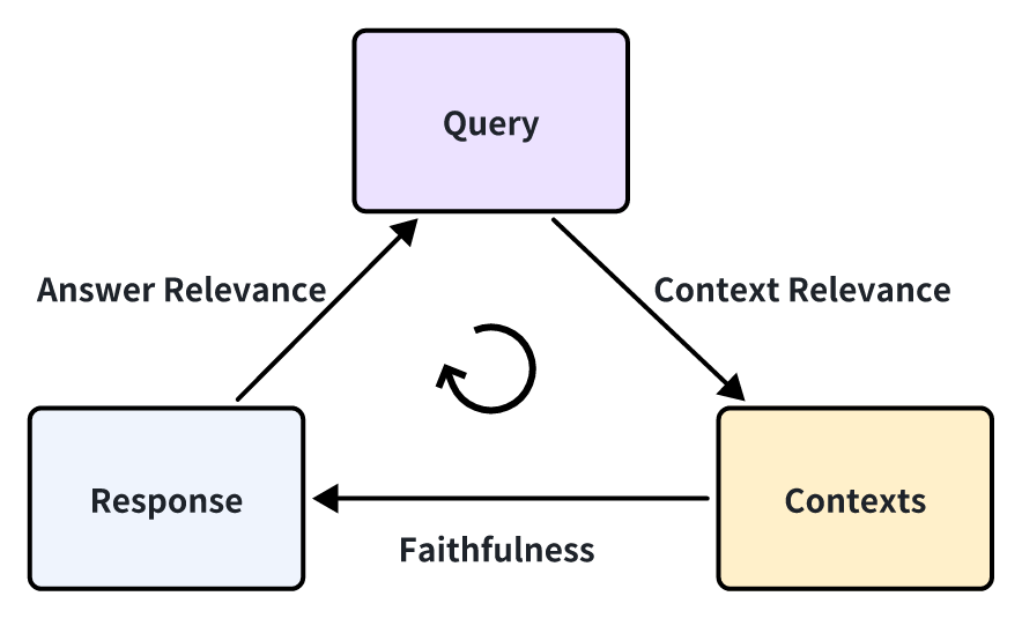